<a href="https://colab.research.google.com/github/R-A-N-N/Stackoverflow-Tag-Predictor/blob/main/SO_TagPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
pip install scikit-multilearn

##All import statements

In [49]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [50]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Loading the database

In [51]:
con = sqlite3.connect('/content/gdrive/My Drive/so_train.db')

In [52]:
pd.read_sql_query('SELECT Title, Body, Tags FROM data', con)

,Title,Body,Tags
0,How can I can read and modify data from XML file?,<p>Please give me the simplest way to read or ...,c# .net xml exception-handling
1,Java 2Dimensional Boolean Array Values,<p>I'm having a problem with my 2 dimensional ...,java multidimensional-array boolean
2,O(1) algorithm to determine if node is descend...,<p>Imagine the following tree:</p>\n\n<pre><co...,algorithm tree trie descendant
3,C++ & DirectX - setting shader,<p>Does someone know a fast way to invoke shad...,c++ performance directx shader
4,How to convert QR code to number?,<p>i have created QR-code through this site <a...,android
...,...,...,...
406396,NetBeans: How to create a web service client t...,<p>I am trying to add a web service reference ...,java web-services ssl wsit
406397,Why does WPF require a STAThread attribute to ...,"<p>I am new to WPF, and in every tutorial I re...",wpf stathread
406398,"When i run aspnet_regsql, nothing is created i...",<p>When i run the aspnet_regsql.exe tool to ad...,.net sql-server-2005
406399,Prime Appearances in Fibonacci Number Factoriz...,"<p>Okay, THIS one is considerably more analyti...",number-theory prime-numbers fibonacci-numbers


In [53]:
con2 = sqlite3.connect('/content/gdrive/My Drive/train_no_dup.db')

## Removing Null values

In [ ]:
pd.read_sql_query('Delete FROM data where Title IS NULL',con2)

In [ ]:
pd.read_sql_query('Delete FROM data where Tags IS NULL',con2)

In [55]:
none = pd.read_sql_query("Select Title,Body,Tags FROM data WHERE Tags IS NULL",con2)
none

,Title,Body,Tags


##Counting the number of rows

In [58]:
num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])

Number of rows in the database : 
 406401


##Checking for duplicates

In [59]:
df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)

In [60]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 9409 ( 2.31520099606054 % )


In [62]:
pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags ORDER BY cnt_dup', con)

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss,1
3,-2) = (1,-\frac{3}{2},-1)$</p>,1
4,1),System.Globalization.CalendarWeekRule.FirstDay,System.DayOfWeek.Sunday);,1
...,...,...,...,...
396987,maven set classes time stamp before packing th...,<p>I want to set the time stamp of the classes...,maven,3
396988,optimality of 2 in a continued fraction theorem,<p>I'm giving some lectures on continued fract...,number-theory continued-fractions,3
396989,parse url and title from string of multiple hr...,<p>i need to parse the url and title from mult...,regex parsing coldfusion,3
396990,send value location continues after 10 minute,<p>i want to send my location into my database...,android database latitude longitude,3


In [63]:
print(len(df_no_dup))

396992


In [64]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    387661
2      9253
3        78
Name: cnt_dup, dtype: int64

## Counting number of tags in each set of question

In [65]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")) if text else 0)
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup

Time taken to run this cell : 0:00:00.284568


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss,1,3
3,-2) = (1,-\frac{3}{2},-1)$</p>,1,2
4,1),System.Globalization.CalendarWeekRule.FirstDay,System.DayOfWeek.Sunday);,1,2
...,...,...,...,...,...
396987,“error: no such device” at boot in Ubuntu Serv...,<p>I have a configuration of 4 HDD's as Raid1 ...,server ubuntu-11.10 raid-1,1,3
396988,“git did not exit cleanly (exit code 128)” err...,<p>I am getting this error on my windows machi...,git tortoisegit git-bash,1,3
396989,“iTunes.app” incoming network connections?,<p>I am experiencing the same issue mentioned ...,itunes osx-lion,1,2
396990,“make & make install” software on Linux,<p>I have worked on Linux for a year. One thin...,linux make,1,2


In [72]:
# distribution of number of tags per question
tag_count = df_no_dup.tag_count.value_counts()
tag_count

3     113343
2     105896
4      76244
1      54661
5      46837
17         2
11         2
10         2
19         1
16         1
14         1
8          1
6          1
Name: tag_count, dtype: int64

<BarContainer object of 13 artists>

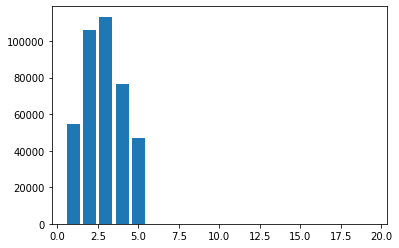

In [73]:
plt.bar(tag_count.keys(),tag_count)

## Analyzing tags

In [67]:
pd.read_sql_query("Select Title,Body,Tags FROM data",con2)

,Title,Body,Tags
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding
2,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss
3,A simple distance inequality in probability,<p>I was going through Durrett's probability w...,probability-theory
4,ASP.NET MVC 3 Single-Page Application using J...,<p>I have recently built an single-page ASP.NE...,javascript jquery asp.net-mvc-3 dom
...,...,...,...
396979,“error: no such device” at boot in Ubuntu Serv...,<p>I have a configuration of 4 HDD's as Raid1 ...,server ubuntu-11.10 raid-1
396980,“git did not exit cleanly (exit code 128)” err...,<p>I am getting this error on my windows machi...,git tortoisegit git-bash
396981,“iTunes.app” incoming network connections?,<p>I am experiencing the same issue mentioned ...,itunes osx-lion
396982,“make & make install” software on Linux,<p>I have worked on Linux for a year. One thin...,linux make


In [68]:
start = datetime.now()
tag_data = pd.read_sql_query("""SELECT Tags FROM data""", con2)
#Always remember to close the database
# Let's now drop unwanted column.
tag_data.drop(tag_data.index[0], inplace=True)
#Printing first 5 columns from our data frame
tag_data


,Tags
1,c# silverlight data-binding
2,java servlets jboss
3,probability-theory
4,javascript jquery asp.net-mvc-3 dom
5,ruby-on-rails ruby-on-rails-3 devise browser-c...
...,...
396979,server ubuntu-11.10 raid-1
396980,git tortoisegit git-bash
396981,itunes osx-lion
396982,linux make


In [ ]:
##Total number of unique tags 


### Counting number of unique tags

In [69]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])


In [74]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 396983
Number of unique tags : 28986


Out of all 396983 entries, there are total 28986 unique tags

In [76]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:20])

Some of the tags we have : ['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.each', '.emf', '.exe', '.htaccess', '.htpasswd', '.ico', '.lib', '.net', '.net-1.0', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5']


## Number of times a tag appeared